<a href="https://colab.research.google.com/github/AndresBrie/Tort3D/blob/main/Paper_Figures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

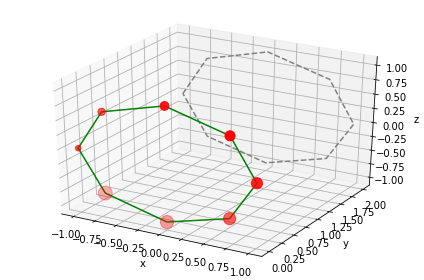

,x,y,z
0,-1.00,0.0,0.00
1,-0.71,0.0,0.71
2,-0.00,0.0,1.00
3,0.71,0.0,0.71
4,1.00,0.0,0.00
5,0.71,0.0,-0.71
6,0.00,0.0,-1.00
7,-0.71,0.0,-0.71
8,-1.00,0.0,0.00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def to_dataframe(x,y,z):
  '''
    Easily convert x,y,z coordinates lists to pandas dataframe

    Parameters
    ----------
    x : arraylike
        x coordinate
    y : arraylike
        y coordinate
    z : arraylike
        z coordinate

    Returns
    -------
    df_coords : Pandas dataframe
        Dataframe with x,y,z columns.

    '''
  data=dict({})
  data['x']=x
  data['y']=y
  data['z']=z
  df_coords=pd.DataFrame(data)
  return df_coords

fig = plt.figure()

nv=8
vertices=(2*np.arange(nv)/nv)*np.pi
vertices=np.append(vertices,0)
x=-np.cos(vertices)
y=np.zeros_like(x)
z=np.sin(vertices)

df_coords=to_dataframe(x,y,z).round(2)

ax  = plt.axes(projection ='3d')
#ax.plot(x,y,np.zeros_like(x),'--',c='black')
ax.plot(x,np.zeros_like(x)+2,z,'--',c='gray')
#ax.plot(np.zeros_like(x),y,z,'--',c='blue')
ax.plot(x,y,z,c='green')
ax.scatter(x,y,z,s=(vertices+1)*30,c='red')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.tight_layout()
plt.show()
#
df_coords

# Slope

Let P be a poligonal curve formed verteces by $\vec{p_1},\vec{p_2},...,\vec{p_n}$, where $\vec{p_i}=(x_i,y_i,z_i)$.


Vectors $\vec{v_i}=\vec{p_{i+1}}-\vec{p_{i}}$ 
i.e. $\vec{v_i}=(x_{i+1}-x_i,y_{i+1}-y_i,z_{i+1}-z_i), i∈{1,2,...,n-1}$.


$\alpha_i=\arccos(\frac{v_i. v_{i+1}}{|v_i||v_{i+1}|}), i∈{1,2,...,n-2}$

$\alpha_i\in [0,\pi)$

To expand $\alpha_j\in(-\pi,\pi)$ we check if the segment containing $\alpha_{i-1},...,α_{j+1} is convex (U-shaped) or concave (Z-shaped)


The steps to set the signs are the following


1.   Set the inital sign $s$ positive $(s=1)$ or negative at will $(s=-1)$. 
2.   Move along the chain by incrementing $i$ until $\alpha_i\ne0$ or $i=n+1$. 
  *   If i=n+1 return the signed chain, otherwise $\alpha_i=s\alpha_i$   
2.   Increment $j$ from $i+1$ until $α_j\ne 0$
  *   If the sequence of segments formed by vertices i and j are Z shaped change the sign of s, i.e. $s ← -s$. 
  *   $\alpha_j=s\alpha_j$.
3.    Repeat step 3





In [3]:
def get_slopes(df_coords,encode=False,sign=1,close_curve=False):
  '''
  Get slope chain from x,y,z coordinates.

  Parameters
  ----------
  df_coords : DataFrame
      Pandas DataFrame containing the x,y,z coordinates of the polygonal curve.

  Returns
  -------
  alpha : Numpy array
      Chain of angles formed between subsequentent vectors. Normalized to [0,1).
  '''
  if encode and np.abs(sign)!=1:
    raise ValueError('sign must be 1 (positive) or -1 (negative).')
  df_vectors=df_coords-df_coords.shift(-1)
  alphas=[]
  i_prev=-1
  for i in range(df_vectors.shape[0]-2):
    a=df_vectors.iloc[i]
    b=df_vectors.iloc[i+1]
    
    num=np.dot(a,b)
    den=np.sqrt(np.sum(a**2)*np.sum(b**2))
    alpha=np.arccos(num/den)
    

    if encode:
      if alpha==0:
        alphas.append(0)
      elif i_prev==-1:
        alphas.append(sign*alpha)
        i_prev=i
      else:
        #print(i_prev,i)
        a1=df_vectors.iloc[i_prev]#
        coefs_h=np.cross(a1,a)#Coeficientes del plano "horizontal"
        coefs_v=np.cross(coefs_h,a)#coeficientes del plano vertical
        #print(np.dot(coefs_v,-a1),np.dot(coefs_v,b))
        if np.dot(coefs_v,-a1)*np.dot(coefs_v,b)<0:#U-shape (change sign)
          sign=-sign
        i_prev=i
        alphas.append(sign*alpha)
    else:
      alphas.append(alpha)
  
  if close_curve:
    if df_coords.iloc[0].equals(df_coords.iloc[-1]):#Curve is already closed
      a=df_vectors.iloc[0]
      b=df_vectors.iloc[-2]
      

      num=np.dot(a,b)
      den=np.sqrt(np.sum(a**2)*np.sum(b**2))
      alphas.append(np.arccos(num/den))
    else:
      a=df_vectors.iloc[-2]
      b=df_coords.iloc[0]-df_coords.iloc[-1]#Missing segment
      c=df_vectors.iloc[0]

      num=np.dot(-a,b)
      den=np.sqrt(np.sum(a**2)*np.sum(b**2))
      alphas.append(np.arccos(num/den))

      num=np.dot(-b,c)
      den=np.sqrt(np.sum(b**2)*np.sum(c**2))
      alphas.append(np.arccos(num/den))

  return np.array(alphas)/np.pi

alphas=get_slopes(df_coords,encode=True,sign=1,close_curve=True)
print("slope chain alpha:",list(np.round(alphas,2)))
print("Acc. slope:",np.round(np.sum(alphas),2))

slope chain alpha: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Acc. slope: 2.0


In [4]:
def get_torsions(df_coords,encode=False,close_curve=False):
  '''
  Get torsion chain from a 3D polygonal curve.

  Parameters
  ----------
  df_coords : DataFrame
      Pandas DataFrame containing the x,y,z coordinates of the polygonal curves' verteces.

  Returns
  -------
  beta : Numpy array
      Chain of torsion angles normalized to (-1,1).
  '''
  df_vectors=df_coords-df_coords.shift(-1)
  betas=[]
  
  
  #alphas=get_slopes(df_coords)
  i1=0
  a=df_vectors.iloc[0].values
  b=df_vectors.iloc[1].values
  cross1=-np.cross(b,a)
  while np.sum(np.abs(cross1))==0 and i1<df_vectors.shape[0]-1:
    print(i1)
    betas.append(0)
    a=b.copy()
    b=df_vectors.iloc[i1+2].values
    cross1=-np.cross(b,a)
    i1+=1
    
  for i in range(i1+2,df_vectors.shape[0]-1):
    
    c=df_vectors.iloc[i].values
    cross2=-np.cross(c,b)
    
    if np.sum(np.abs(cross2))==0:
      betas.append(0)
    else:

      num=np.abs(np.dot(cross1,cross2))
      den=np.sqrt(np.sum(cross1**2))*np.sqrt(np.sum(cross2**2))
      #print(i,num/den,-np.arccos(num/den))
      if encode and np.dot(cross1,c)>0:
        
        betas.append(-np.arccos(num/den))
      else:
        betas.append(np.arccos(num/den))
      a=b
      b=c
    cross1=np.cross(a,b)

  if close_curve:
    if df_coords.iloc[-1].equals(df_coords.iloc[-1]):#Curve is already closed
      c=df_vectors.iloc[0].values
      cross2=-np.cross(c,b)
      if np.sum(np.abs(cross2))==0:
        betas.append(0)
      else:
        num=np.abs(np.dot(cross1,cross2))
        den=np.sqrt(np.sum(cross1**2))*np.sqrt(np.sum(cross2**2))
        if encode and np.dot(cross1,c)>=0:
          betas.append(-np.arccos(num/den))
        else:
          betas.append(np.arccos(num/den))
        a=b
        b=c
      cross1=np.cross(a,b)

      c=df_vectors.iloc[1].values
      cross2=-np.cross(c,b)
      if np.sum(np.abs(cross2))==0:
        betas.append(0)
      else:
        num=np.abs(np.dot(cross1,cross2))
        den=np.sqrt(np.sum(cross1**2))*np.sqrt(np.sum(cross2**2))
        if encode and np.dot(cross1,c)>0:
          betas.insert(0,-np.arccos(num/den))
        else:
          betas.insert(0,np.arccos(num/den))
      
  return np.array(betas)/np.pi

betas=get_torsions(df_coords)
betas

array([0., 0., 0., 0., 0., 0.])

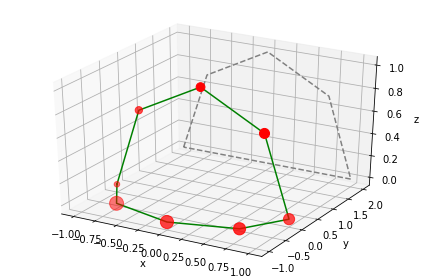

slope chain (alpha): [-0.25, -0.25, -0.25, -0.55, -0.25, -0.25, -0.25, 0.55]
Acc. slope: -1.51
Torsion chain (beta): [ 0.38  0.    0.   -0.38  0.38  0.    0.   -0.38]
Acc. Torsion: 0.0
Acc. Abs. Torsion: 1.54
Tortuosity: -1.51


In [5]:


x=-np.cos(vertices)
y=np.concatenate([np.zeros(nv//2),np.sin(vertices[len(vertices)//2:])])
z=np.concatenate([-np.sin(vertices[len(vertices)//2:]),np.zeros(nv//2)])

df_coords=to_dataframe(x,y,z).round(2)

ax  = plt.axes(projection ='3d')
#ax.plot(x,y,np.zeros_like(x),'--',c='black')
ax.plot(x,np.zeros_like(x)+2,z,'--',c='gray')
#ax.plot(np.zeros_like(x),y,z,'--',c='blue')
ax.plot(x,y,z,c='green')
ax.scatter(x,y,z,s=(vertices+1)*30,c='red')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.tight_layout()
plt.show()

alphas=get_slopes(df_coords,encode=True,sign=-1,close_curve=True)
print("slope chain (alpha):",list(np.round(alphas,2)))
print("Acc. slope:",np.round(np.sum(alphas),2))
betas=get_torsions(df_coords,encode=True,close_curve=True)

print("Torsion chain (beta):",np.round(betas,2))
print("Acc. Torsion:",np.round(np.sum(betas),2))
print("Acc. Abs. Torsion:",np.round(np.sum(np.abs(betas)),2))

print("Tortuosity:",np.round(np.sum(alphas)+np.sum(betas),2))

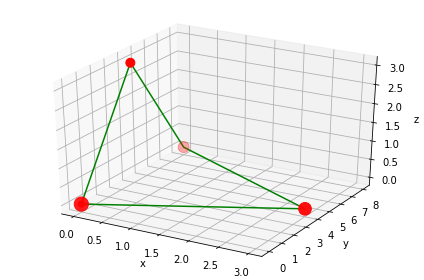

   x  y  z
0  0  0  0
1  0  4  3
2  0  8  0
3  3  4  0
4  0  0  0
slope chain (alpha): [0.41, 0.72, 0.41, 0.72]
Acc. Slope: 2.26
Acc. Abs. Slope: 2.26
5 4
Torsion chain (beta): [ 0.29 -0.29  0.29 -0.29]
Acc. Torsion: 0.0
Acc. Abs. Torsion: 1.14
Tortuosity: 3.4


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#x=[0,1,1,2,2,2,1,0,0]
#y=[0,0,1,1,1,0,0,0,0]
#z=[1,1,1,1,0,0,0,0,1]
#x=[0,0,0,1,1,1,0]
#y=[0,1,1,1,0,0,0]
#z=[0,0,1,1,1,0,0]
x=[0,0,0,3,0]
y=[0,4,8,4,0]
z=[0,3,0,0,0]
df_coords=to_dataframe(x,y,z).round(2)

ax  = plt.axes(projection ='3d')
#ax.plot(x,y,np.zeros_like(x),'--',c='black')
#ax.plot(x,np.zeros_like(x)+2,z,'--',c='gray')
#ax.plot(np.zeros_like(x),y,z,'--',c='blue')
ax.plot(x,y,z,c='green')
ax.scatter(x,y,z,s=(np.arange(len(x))+1)*40,c='red')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.tight_layout()
plt.show()

print(df_coords)
alphas=get_slopes(df_coords,close_curve=True,encode=True)
print("slope chain (alpha):",list(np.round(alphas,2)))
print("Acc. Slope:",np.round(np.sum(alphas),2))
print("Acc. Abs. Slope:",np.round(np.sum(np.abs(alphas)),2))

betas=get_torsions(df_coords,close_curve=True,encode=True)
print(len(x),len(betas))

print("Torsion chain (beta):",np.round(betas,2))
print("Acc. Torsion:",np.round(np.sum(betas),2))
print("Acc. Abs. Torsion:",np.round(np.sum(np.abs(betas)),2))

print("Tortuosity:",np.round(np.sum(np.abs(alphas))+np.sum(np.abs(betas)),2))

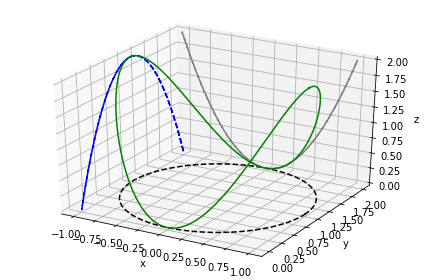

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#x=[0,1,1,2,2,2,1,0,0]
#y=[0,0,1,1,1,0,0,0,0]
#z=[1,1,1,1,0,0,0,0,1]
#x=[0,0,0,1,1,1,0]
#y=[0,1,1,1,0,0,0]
#z=[0,0,1,1,1,0,0]
n_angulos=1000
t=np.arange(-1,n_angulos+2)/n_angulos
theta=2*np.pi*t

x=np.cos(theta)
y=1+np.sin(theta)
z=1+np.cos(2*theta)


ax  = plt.axes(projection ='3d')
ax.plot(x,y,np.zeros_like(x),'--',c='black')
ax.plot(x,np.zeros_like(x)+2,z,'--',c='gray')
ax.plot(np.zeros_like(x)-1,y,z,'--',c='blue')
ax.plot(x,y,z,c='green')
#ax.scatter(x,y,z,s=(np.arange(len(x))+1)*40,c='red')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.tight_layout()
plt.show()



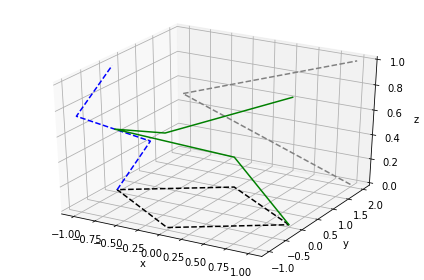

slope chain (alpha): [0.4904, 0.4904, 0.4904]
Acc. Slope: 1.47
Acc. Abs. Slope: 1.47
5 2
Torsion chain (beta): [0.11 0.11]
Acc. Torsion: 0.22
Acc. Abs. Torsion: 0.22
Tortuosity: 1.69


,x,y,z
0,1.0,0.0,0.00
1,0.0,1.0,0.25
2,-1.0,0.0,0.50
3,-0.0,-1.0,0.75
4,1.0,-0.0,1.00


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#x=[0,1,1,2,2,2,1,0,0]
#y=[0,0,1,1,1,0,0,0,0]
#z=[1,1,1,1,0,0,0,0,1]
#x=[0,0,0,1,1,1,0]
#y=[0,1,1,1,0,0,0]
#z=[0,0,1,1,1,0,0]
n_angulos=4
t=np.arange(0,n_angulos+1)/n_angulos
theta=2*np.pi*t

x=np.cos(theta)
y=np.sin(theta)
z=t

df_coords=to_dataframe(x,y,z).round(2)

ax  = plt.axes(projection ='3d')
ax.plot(x,y,np.zeros_like(x),'--',c='black')
ax.plot(x,np.zeros_like(x)+2,z,'--',c='gray')
ax.plot(np.zeros_like(x)-1,y,z,'--',c='blue')
ax.plot(x,y,z,c='green')
#ax.scatter(x,y,z,s=(np.arange(len(x))+1)*40,c='red')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.tight_layout()
plt.show()

alphas=get_slopes(df_coords)
print("slope chain (alpha):",list(np.round(alphas,4)))
print("Acc. Slope:",np.round(np.sum(alphas),2))
print("Acc. Abs. Slope:",np.round(np.sum(np.abs(alphas)),2))

betas=get_torsions(df_coords)
print(len(x),len(betas))

print("Torsion chain (beta):",np.round(betas,2))
print("Acc. Torsion:",np.round(np.sum(betas),2))
print("Acc. Abs. Torsion:",np.round(np.sum(np.abs(betas)),2))

print("Tortuosity:",np.round(np.sum(np.abs(alphas))+np.sum(np.abs(betas)),2))
df_coords

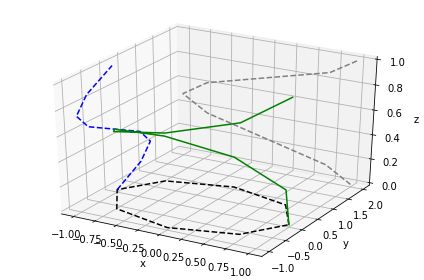

slope chain (alpha): [0.2497, 0.2432, 0.2497, 0.2437, 0.2497, 0.2432, 0.2497]
Acc. Slope: 1.73
Acc. Abs. Slope: 1.73
9 6
Torsion chain (beta): [0.04 0.04 0.05 0.05 0.04 0.04]
Acc. Torsion: 0.25
Acc. Abs. Torsion: 0.25
Tortuosity: 1.97


,x,y,z
0,1.00,0.00,0.00
1,0.71,0.71,0.12
2,0.00,1.00,0.25
3,-0.71,0.71,0.38
4,-1.00,0.00,0.50
5,-0.71,-0.71,0.62
6,-0.00,-1.00,0.75
7,0.71,-0.71,0.88
8,1.00,-0.00,1.00


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#x=[0,1,1,2,2,2,1,0,0]
#y=[0,0,1,1,1,0,0,0,0]
#z=[1,1,1,1,0,0,0,0,1]
#x=[0,0,0,1,1,1,0]
#y=[0,1,1,1,0,0,0]
#z=[0,0,1,1,1,0,0]
n_angulos=8
t=np.arange(0,n_angulos+1)/n_angulos
theta=2*np.pi*t

x=np.cos(theta)
y=np.sin(theta)
z=t

df_coords=to_dataframe(x,y,z).round(2)

ax  = plt.axes(projection ='3d')
ax.plot(x,y,np.zeros_like(x),'--',c='black')
ax.plot(x,np.zeros_like(x)+2,z,'--',c='gray')
ax.plot(np.zeros_like(x)-1,y,z,'--',c='blue')
ax.plot(x,y,z,c='green')
#ax.scatter(x,y,z,s=(np.arange(len(x))+1)*40,c='red')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.tight_layout()
plt.show()

alphas=get_slopes(df_coords)
print("slope chain (alpha):",list(np.round(alphas,4)))
print("Acc. Slope:",np.round(np.sum(alphas),2))
print("Acc. Abs. Slope:",np.round(np.sum(np.abs(alphas)),2))

betas=get_torsions(df_coords)
print(len(x),len(betas))

print("Torsion chain (beta):",np.round(betas,2))
print("Acc. Torsion:",np.round(np.sum(betas),2))
print("Acc. Abs. Torsion:",np.round(np.sum(np.abs(betas)),2))

print("Tortuosity:",np.round(np.sum(np.abs(alphas))+np.sum(np.abs(betas)),2))
df_coords

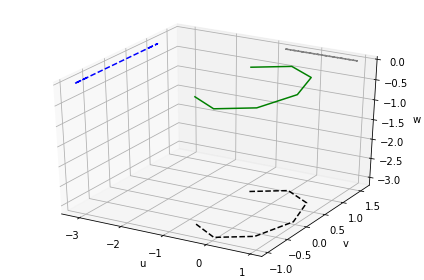

In [10]:
u1=(x[1:]-x[:-1])/(theta[1]-theta[0])
v1=(y[1:]-y[:-1])/(theta[1]-theta[0])
w1=(z[1:]-z[:-1])/(theta[1]-theta[0])
u=u1/np.sqrt(u1**2+v1**2+w1**2)
v=v1/np.sqrt(u1**2+v1**2+w1**2)
w=w1/np.sqrt(u1**2+v1**2+w1**2)
ax = plt.axes(projection ='3d')

u2,v2,w2=(u[1:]-u[:-1],v[1:]-v[:-1],w[1:]-w[:-1])/(theta[1]-theta[0])
ax.plot(u2,v2,np.zeros_like(u2)-np.pi,'--',c='black')
ax.plot(u2,np.zeros_like(u2)+np.pi/2,w2,'--',c='gray')
ax.plot(np.zeros_like(u2)-np.pi,v2,w2,'--',c='blue')
ax.plot(u2,v2,w2,c='green')
#ax.scatter(x,y,z,s=(np.arange(len(x))+1)*40,c='red')
ax.set_xlabel('u')
ax.set_ylabel('v')
ax.set_zlabel('w')
plt.tight_layout()
plt.show()

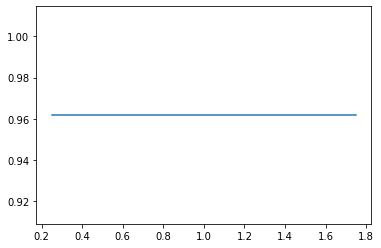

In [11]:
plt.plot(theta[1:-1]/np.pi,np.sqrt(u2**2+v2**2+w2**2))

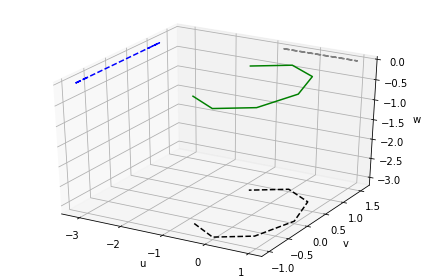

In [12]:
u3,v3,w3=(u2,v2,w2)/np.sqrt(u2**2+v2**2+w2**2)
ax = plt.axes(projection ='3d')
ax.plot(u3,v3,np.zeros_like(u2)-np.pi,'--',c='black')
ax.plot(u3,np.zeros_like(u2)+np.pi/2,w3,'--',c='gray')
ax.plot(np.zeros_like(u2)-np.pi,v3,w3,'--',c='blue')
ax.plot(u3,v3,w3,c='green')
#ax.scatter(x,y,z,s=(np.arange(len(x))+1)*40,c='red')
ax.set_xlabel('u')
ax.set_ylabel('v')
ax.set_zlabel('w')
plt.tight_layout()
plt.show()

Reconstruccion

1.   Construir agregar vertices $(0,0,0)$,$(l_0,0,0)$ y ,$(l_0+l_1\cos(\pi\alpha_1),l_1\sin(\pi\alpha_1),0)$.
  *   Vectores unitarios de dirección:
    * Vector 0: $\vec{v_0}= (u_0,v_0,w_0)=(1,0,0)$, inicial
    * Vector 1: $\vec{v_1}= (u_1,v_1,w_1)=R_z\vec{v_0}=(\cos(\pi\alpha_1),\sin(\pi\alpha_1),0)$ 
2.   Generar nuevo vector de dirección
  *   El vector 2  respecto a $xyz$ es $\vec{ w_2}=(\cos(\pi\alpha_2)\cos(\pi\beta_2),\sin(\pi\alpha_2)\cos(\pi\beta_2),\sin(\pi\beta_2))$
  






$R_z(\pi\alpha)=\begin{bmatrix}
\cos(\pi\alpha) & -\sin(\pi\alpha) & 0 \\
\sin(\pi\alpha) & \cos(\pi\alpha) & 0 \\
0 & 0 & 1 
\end{bmatrix} $

$R_x(\pi\beta)=\begin{bmatrix}
1 & 0 & 0 \\
0 & \cos(\pi\beta) & -\sin(\pi\beta) \\
0 & \sin(\pi\beta) & \cos(\pi\beta) 
\end{bmatrix} $

$R_{xz}(\alpha,\beta)=R_x(\pi\beta)R_z(\pi\alpha)\vec v=\begin{bmatrix}
1 & 0 & 0 \\
0 & \cos(\pi\beta) & -\sin(\pi\beta) \\
0 & \sin(\pi\beta) & \cos(\pi\beta) 
\end{bmatrix}$
$\begin{bmatrix}
\cos(\pi\alpha) & -\sin(\pi\alpha) & 0 \\
\sin(\pi\alpha) & \cos(\pi\alpha) & 0 \\
0 & 0 & 1 
\end{bmatrix} $
$\begin{bmatrix}
u_1\\
v_1\\
w_1\\
\end{bmatrix} $



$=\begin{bmatrix}
\cos(\pi\alpha) & -\sin(\pi\alpha) & 0 \\
\sin(\pi\alpha)\cos(\pi\beta) & \cos(\pi\alpha)\cos(\pi\beta) & -\sin(\pi\beta) \\
\sin(\pi\alpha)\sin(\pi\beta) & \cos(\pi\alpha)\sin(\pi\beta) & \cos(\pi\beta) 
\end{bmatrix}
\begin{bmatrix}
u_1\\
v_1\\
w_1\\
\end{bmatrix}
=\begin{bmatrix}
u_2\\
v_2\\
w_2\\
\end{bmatrix} $




1.   $\vec v_0=(1,0,0)$
2.   $\vec v_1=R_z(\pi\alpha_1) \vec v_0=(\cos(\pi\alpha_1),\sin(\pi\alpha_1),0)$
3.   $\vec v_2=R_z(\pi\alpha_1)R_{xz}(\alpha_2,\beta_2)\vec v_0$
3.   $\vec v_3=R_z(\pi\alpha_1)R_{xz}(\alpha_2,\beta_2)R_{xz}(\alpha_3,\beta_3)\vec v_0$

alphas:  [0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98
 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98
 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98
 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98]
betas: [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


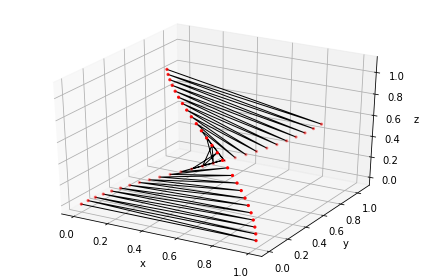

In [13]:
def R_z(vec,alpha):
  x=vec[0]
  y=vec[1]
  u=x*np.cos(alpha)-y*np.sin(alpha)
  v=x*np.sin(alpha)+y*np.cos(alpha)
  w=vec[2]
  return np.array([u,v,w])

def R_x(vec,beta):
  x=vec[0]
  y=vec[1]
  z=vec[2]
  u=x
  v=y*np.cos(beta)-z*np.sin(beta)
  w=y*np.sin(beta)+z*np.cos(beta)
  return np.array([u,v,w])


def decode_simple(alphas,betas,lengths=1):
  '''
  Construct poligonal curve from chains

  Parameters
  ----------
  alphas: arraylike, size n
    Slope chain

  betas: arraylike, size n-1
    Torsion chain
  
  lengths: arraylike, size n+1
    Segment lengths chain
    
  Returns
  -------
  df_coords : DataFrame
      Pandas DataFrame containing the x,y,z coordinates of the polygonal curves' verteces.
'''
  print('alphas: ',alphas)
  print('betas:',betas)
  alphas=alphas*np.pi
  betas=betas*np.pi
  if np.isscalar(lengths):
    lengths=np.ones(len(alphas)+1)*lengths

  p=[np.array([0,0,0]),np.array([lengths[0],0,0])]#Points
  vecs=[np.array([1,0,0])]# 2 points form 1 vector
  vec=R_z(vecs[0],alphas[0])
  vecs.append(vec)
  p.append(p[-1]+lengths[1]*vec)
  for i in range(len(betas)):
    vec=vecs[0]
    for j in range(i,-1,-1):
      beta=betas[i]
      vec=R_z(vec,alphas[i+1])
      vec=R_x(vec,betas[i])
    vec=R_z(vec,alphas[0])
    vecs.append(vec)
    p.append(p[-1]+lengths[i+2]*vec)
    
  return pd.DataFrame(p,columns=['x','y','z'])


alphas=np.ones(50)*.98
betas=np.ones(len(alphas)-1)*.5
df_rec=decode_simple(alphas,betas,lengths=1)
ax  = plt.axes(projection ='3d')
x1=df_rec['x']
y1=df_rec['y']
z1=df_rec['z']
#ax.plot(x1,y1,np.zeros_like(x1),'--',c='green')
#ax.plot(x1,np.zeros_like(x1)+2,z1,'--',c='gray')
#ax.plot(np.zeros_like(x1),y1,z1,'--',c='blue')
ax.plot(x1,y1,z1,c='black',linewidth=1)
ax.scatter(x1,y1,z1,c='red',s=5)
#ax.scatter(x1,[0],[0],s=30,c='red')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.tight_layout()
#plt.show()
#(df_rec.iloc[1:]-df_rec.iloc[:-1])**2
df_vecs=df_rec.shift(-1)-df_rec
plt.savefig("MaxTort.eps",format="eps")
#df_vecs.iloc[:-1]
#print(df_rec)
#print(df_vecs.iloc[:-1])

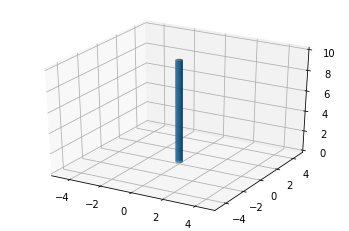

In [14]:
def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    z = np.linspace(0, height_z, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

Xc,Yc,Zc = data_for_cylinder_along_z(0,0,.2,10)
ax.plot_surface(Xc, Yc, Zc)
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)

plt.savefig("MinTort.eps",format="eps")

alphas:  [0.5 0.5 0.5 0.5 0.5]
betas: [0.5 0.5 0.5 0.5]


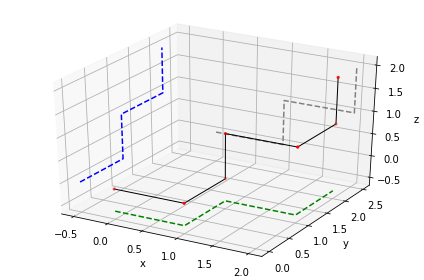

,x,y,z
0,0.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,1.0,0.0
3,1.0,1.0,1.0
4,2.0,1.0,1.0
5,2.0,2.0,1.0
6,2.0,2.0,2.0


In [71]:

n_alphas=5
alphas=np.ones(n_alphas)*.5
betas=np.ones(len(alphas)-1)*.5
df_rec=decode_simple(alphas,betas,lengths=1)
ax  = plt.axes(projection ='3d')
x1=df_rec['x']
y1=df_rec['y']
z1=df_rec['z']
ax.plot(x1,y1,np.zeros_like(x1)-.5,'--',c='green')
ax.plot(x1,np.zeros_like(x1)+2.5,z1,'--',c='gray')
ax.plot(np.zeros_like(x1)-.5,y1,z1,'--',c='blue')
ax.plot(x1,y1,z1,c='black',linewidth=1)
ax.scatter(x1,y1,z1,c='red',s=5)
#ax.scatter(x1,[0],[0],s=30,c='red')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.tight_layout()
#plt.show()
#(df_rec.iloc[1:]-df_rec.iloc[:-1])**2
df_vecs=df_rec.shift(-1)-df_rec
plt.show()
#plt.savefig("MaxTort.eps",format="eps")
#df_vecs.iloc[:-1]
df_rec
#print(df_vecs.iloc[:-1])

alphas:  [0.21428571 0.21428571 0.21428571 0.21428571 0.21428571 0.21428571
 0.21428571 0.21428571 0.21428571 0.21428571 0.21428571]
betas: [0.21428571 0.21428571 0.21428571 0.21428571 0.21428571 0.21428571
 0.21428571 0.21428571 0.21428571 0.21428571]


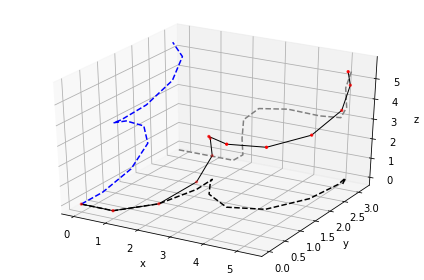

,x,y,z
0,0.000000,0.000000,0.000000
1,1.000000,0.000000,0.000000
2,1.781831,0.623490,0.000000
3,2.089163,1.492068,0.388740
4,2.057162,2.025118,1.234218
5,2.100972,1.918857,2.227591
6,2.573185,1.396986,2.937989
7,3.472929,1.026113,3.168018
8,4.446586,1.248263,3.116628
9,5.079554,2.016172,3.214957


In [68]:
alphas=np.ones(2*n_alphas+1)*(n_alphas-.5)/(n_alphas*4+1)
betas=np.ones(len(alphas)-1)*(n_alphas-.5)/(n_alphas*4+1)
df_rec=decode_simple(alphas,betas,lengths=1)
ax  = plt.axes(projection ='3d')
x1=df_rec['x']
y1=df_rec['y']
z1=df_rec['z']
ax.plot(x1,y1,np.zeros_like(x1),'--',c='black')
ax.plot(x1,np.zeros_like(x1)+3,z1,'--',c='gray')
ax.plot(np.zeros_like(x1),y1,z1,'--',c='blue')
ax.plot(x1,y1,z1,c='black',linewidth=1)
ax.scatter(x1,y1,z1,c='red',s=5)
#ax.scatter(x1,[0],[0],s=30,c='red')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.tight_layout()
#plt.show()
#(df_rec.iloc[1:]-df_rec.iloc[:-1])**2
df_vecs=df_rec.shift(-1)-df_rec
plt.show()
#plt.savefig("MaxTort.eps",format="eps")
#df_vecs.iloc[:-1]
df_rec
#print(df_vecs.iloc[:-1])

alphas:  [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
betas: [0.5 0.5 0.5 0.5 0.5 0.5 0.5]
     x    y    z
0  0.0  0.0  0.0
2  1.0  1.0  0.0
4  2.0  1.0  1.0
6  2.0  2.0  2.0
8  3.0  3.0  2.0


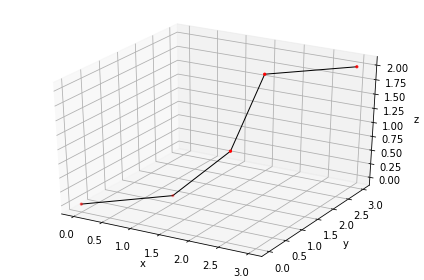

[0.33333333 0.33333333 0.33333333]
[0.39182655 0.39182655]


In [48]:
df_rec2=decode_simple(alphas,betas,lengths=1).iloc[::2]
ax  = plt.axes(projection ='3d')

x2=df_rec2['x']
y2=df_rec2['y']
z2=df_rec2['z']
#ax.plot(x1,y1,np.zeros_like(x1),'--',c='green')
#ax.plot(x1,np.zeros_like(x1)+2,z1,'--',c='gray')
#ax.plot(np.zeros_like(x1),y1,z1,'--',c='blue')
ax.plot(x2,y2,z2,c='black',linewidth=1)
ax.scatter(x2,y2,z2,c='red',s=5)
#ax.scatter(x1,[0],[0],s=30,c='red')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.tight_layout()
#plt.show()
#(df_rec.iloc[1:]-df_rec.iloc[:-1])**2
df_vecs=df_rec2.shift(-1)-df_rec2
df_vecs=df_vecs.round(10)
print(df_rec2)
alphas2=get_slopes(df_rec2)
betas2=get_torsions(df_rec2)
plt.show()
#plt.savefig("MaxTort.eps",format="eps")
#df_vecs.iloc[:-1]
print(alphas2)
print(betas2)
#df_vecs
#print(df_vecs.iloc[:-1])

In [22]:
np.arccos(.5)/np.pi

0.33333333333333337

Dada una curva $\alpha=.5,.5,.5,.5$ y $\beta=.5, .5, .5$